# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
!pip install --upgrade gensim
!pip install --upgrade xgboost

     |████████████████████████████████| 23.9MB 126kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 166.7MB 70kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
from sklearn import tree
from io import StringIO
from wordcloud import WordCloud
from IPython.display import display, HTML, Image
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
os.chdir(r'/content/drive/MyDrive/AI/AppliedAI/Datasets')

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:20<00:00, 2288.26it/s]


In [26]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 46071/46071 [00:18<00:00, 2431.63it/s]


In [28]:
preprocessed_summary[1500]

'gym rat bargain'

In [29]:
preprocessed_combinedText=[]
for i in range(0, len(preprocessed_reviews)):
    preprocessed_combinedText.append(preprocessed_reviews[i]+ ' ' + preprocessed_summary[i])

In [30]:
print(preprocessed_reviews[1500])
print('-----------------------------------')
print(preprocessed_summary[1500])
print('-----------------------------------')
print(preprocessed_combinedText[1500])

great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based
-----------------------------------
gym rat bargain
-----------------------------------
great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based gym rat bargain


In [31]:
print(len(preprocessed_reviews))
print(len(preprocessed_summary))
print(len(preprocessed_combinedText))

46071
46071
46071


In [32]:
final['CleanedText']=preprocessed_combinedText
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [33]:
final['Text'].shape

(46071,)

In [34]:
#Sorting based on Time
final['Time'] = pd.to_datetime(final['Time'], origin='unix', unit='s')
final = final.sort_values('Time')
print(final.shape)
print(final['Time'].head(1000))

(46071, 11)
1146    2000-06-23
1145    2000-06-29
28086   2003-10-25
28087   2003-10-25
38740   2003-10-31
           ...    
2873    2007-02-14
6560    2007-02-14
30910   2007-02-15
47172   2007-02-15
40986   2007-02-15
Name: Time, Length: 1000, dtype: datetime64[ns]


In [35]:
#Splitting Data into Train CV and Test
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(final['CleanedText'], final['Score'], test_size=.30, random_state=64)

In [36]:
print([i.shape for i in [X_train,X_test, Y_train, Y_test]])

[(32249,), (13822,), (32249,), (13822,)]


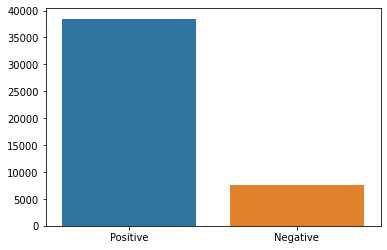

1    38479
0     7592
Name: Score, dtype: int64


In [37]:
sns.barplot(x=['Positive','Negative'], y=final['Score'].value_counts().values)
plt.show()

print(final['Score'].value_counts())

In [38]:
final_value_counts=final['Score'].value_counts()
positiveClassPercentage=((final_value_counts.sum() - final_value_counts[0])/final_value_counts.sum())*100
negativeClassPercentage=100-positiveClassPercentage
print('Percentage of Positive reviews- {} %'.format(round(positiveClassPercentage, 2)))
print('Percentage of Negative reviews- {} %'.format(round(negativeClassPercentage, 2)))

Percentage of Positive reviews- 83.52 %
Percentage of Negative reviews- 16.48 %


# [4] Featurization

## [4.1] BAG OF WORDS

In [39]:
#Compute BoW
countVector=CountVectorizer(ngram_range=(1,4), min_df=5, max_features=5000)
bow_train=countVector.fit_transform(X_train)

bow_test=countVector.transform(X_test)

print(list(map(type, [bow_train,bow_test])))
print('Shape of bow_train is: ', bow_train.shape)
print('Shape of bow_test is: ', bow_test.shape)


[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (32249, 5000)
Shape of bow_test is:  (13822, 5000)


## [4.3] TF-IDF

In [40]:
#Compute tfidf
tfidfVector = TfidfVectorizer(ngram_range=(1,2), min_df=5,  max_features=500)
tfidf_train=tfidfVector.fit_transform(X_train)
tfidf_test=tfidfVector.transform(X_test)

print(list(map(type, [tfidf_train,tfidf_test])))
print('Shape of tfidf_train is: ', tfidf_train.shape)
print('Shape of tfidf_test is: ', tfidf_test.shape)

[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of tfidf_train is:  (32249, 500)
Shape of tfidf_test is:  (13822, 500)


## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [41]:
# Train your own Word2Vec model using your own text corpus
# average Word2Vec for train, validation and test data 
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

#avgw2v for train data
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#avgw2v for test data
sent_vectors_test = []
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


  0%|          | 66/13822 [00:00<00:22, 607.94it/s]

32249
50


100%|██████████| 13822/13822 [00:25<00:00, 540.85it/s]

13822
50


In [42]:
avgw2v_train=sent_vectors_train
avgw2v_test=sent_vectors_test

#### [4.4.1.2] TFIDF weighted W2v

In [43]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#TFIDF weighted W2V for train data
tfidf_sent_vectors_train = []
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#TFIDF weighted W2V for test data
list_of_sentance_test=[]
tfidf_sent_vectors_test = []
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 13822/13822 [00:35<00:00, 393.44it/s]


In [44]:
tfidf_w2v_train=tfidf_sent_vectors_train
tfidf_w2v_test=tfidf_sent_vectors_test

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.2] Applying GBDT using XGBOOST

In [61]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

def XGBGridsearchcv(trainData, trainLabels, testData, testLabels):
    
    #specify all the parameters
    params = {'objective':['binary:logistic'],
              'n_estimators':[i for i in range(300, 601, 100)],
              'max_depth':[10,12,14,17], 
              'booster': ['gbtree'],
              'scale_pos_weight':[0.2],
              'eval_metric':['auc'],
              'tree_method': ['hist'],
              #'updater':['grow_gpu_hist'],
              'predictor':['cpu_predictor']
              }

    #define DecisionTree model
    xgb = XGBClassifier(random_state=42, n_jobs=-1)
    xgb.fit(trainData, trainLabels)
    grid = GridSearchCV (estimator=xgb, param_grid=params, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1, 
                         return_train_score=True)
    grid.fit(trainData, trainLabels)


    optimum_params=grid.best_params_
    print('Best parameters are: {}'.format(optimum_params))


    pvt_train = pd.pivot_table(pd.DataFrame(grid.cv_results_),
                               values='mean_train_score', index='param_n_estimators', 
                               columns='param_max_depth')

    pvt_cv = pd.pivot_table(pd.DataFrame(grid.cv_results_),
                              values='mean_test_score', index='param_n_estimators', 
                              columns='param_max_depth')

    #plot the performance of model both on train data and cross validation data for each hyper parameter
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
    sns.heatmap(pvt_train, annot=True, ax=ax1)
    sns.heatmap(pvt_cv, annot=True, ax=ax2)
    ax1.title.set_text('Performance of model on Train data')
    ax2.title.set_text('Performance of model on CV data')
    plt.show()

    fig = plot_roc_curve( xgb, trainData, Y_train, linestyle='--', ax=plt.gca(), label="Train ROC")
    fig = plot_roc_curve( xgb, testData, Y_test, ax = fig.ax_, label="Validation ROC")
    fig.figure_.suptitle("ROC Curve on Train and Validation data")
    plt.show() 

    return optimum_params

In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve


def xgbClassifireModel(trainData, trainLabels, testData, testLabels, optimum_params):
    
    global xgb_clf
    xgb_clf = XGBClassifier(    objective='binary:logistic' ,
                                n_estimators= optimum_params['n_estimators'],
                                max_depth=optimum_params['max_depth']  ,
                                eval_metric='auc',
                                booster='gbtree',
                                random_state=42,
                                n_jobs= -1,
                                scale_pos_weight=0.2,
                                verbosity = 1,
                                tree_method= 'hist',
                                #updater= 'grow_gpu_hist',
                                predictor='cpu_predictor'
                                )
    
    xgb_clf.fit(trainData, trainLabels)
    print("Best AUC score on optimum parameters is: {}"\
                                    .format( round(roc_auc_score(testLabels,xgb_clf.predict_proba(testData)[:, 1]), 5)))

    #plot ROC AUC Curve
    fig = plot_roc_curve( xgb_clf, trainData, Y_train, linestyle='--', ax=plt.gca(), label="Train ROC")
    fig = plot_roc_curve( xgb_clf, testData, Y_test, ax = fig.ax_, label="Test ROC")
    fig.figure_.suptitle("ROC Curve on Train and Test data")
    plt.show()  
    
    #Plot confusion matrix
    confusion_mat=confusion_matrix(testLabels, xgb_clf.predict(testData))
    df_confusion_matrix=pd.DataFrame(confusion_mat, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
    sns.heatmap(df_confusion_matrix, annot=True, fmt="d")
    plt.title("ROC AUC Curve")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.legend('right bottom')
    plt.show()
    

In [47]:
def getImportantFeatures(clf, count_vector):
    zipped_values=list(zip(count_vector.get_feature_names(), clf.feature_importances_))
    sorted_values=sorted(zipped_values, key=lambda x: x[1], reverse=True)
    
    return pd.DataFrame(sorted_values, 
                        columns=['Features', 'Gini Importance'], 
                        index=np.arange(1, len(sorted_values)+1))[:20]

In [48]:
def displayWordCould(df):
    wordCloud = WordCloud(collocations = False, background_color = 'white')\
                            .generate(' '.join(df))

    # Display the generated Word Cloud
    plt.figure(figsize=(10,8))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show('\n')

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

[02:35:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 52.7min finished


Best parameters are: {'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 10, 'n_estimators': 500, 'predictor': 'auto', 'scale_pos_weight': 0.2, 'tree_method': 'hist'}


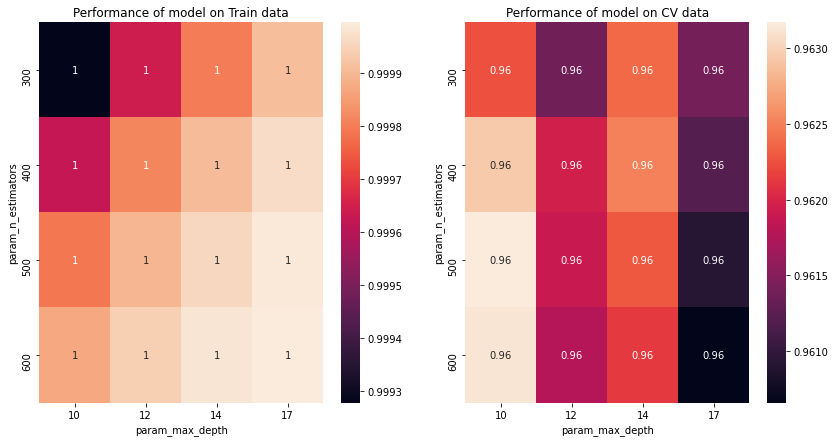

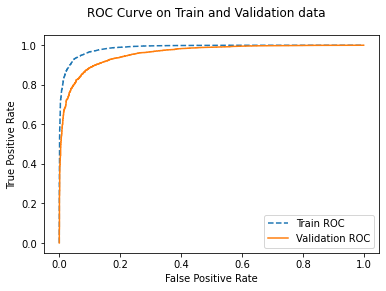

In [ ]:
optimum_params_bow_xgb=XGBGridsearchcv(bow_train, Y_train, bow_test, Y_test)

Best AUC score on optimum parameters is: 0.96761


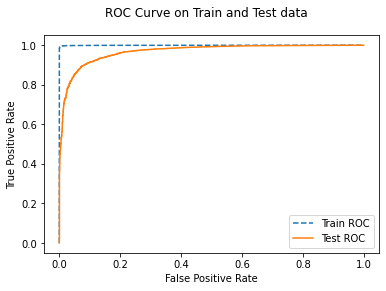

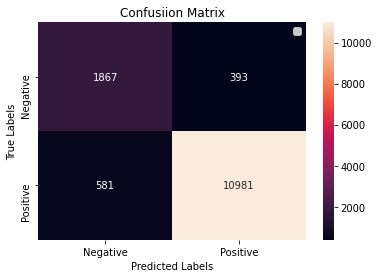

In [ ]:
xgbClassifireModel(bow_train, Y_train, bow_test, Y_test, optimum_params_bow_xgb)

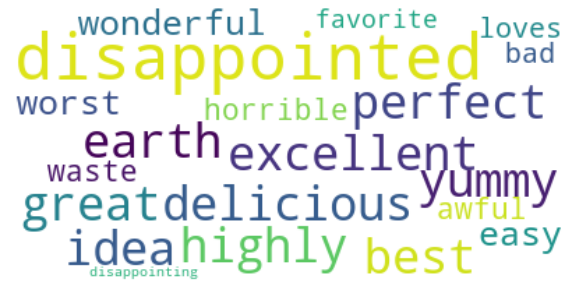

,Features,Gini Importance
1,delicious,0.012141
2,earth,0.011211
3,not disappointed,0.007945
4,perfect,0.007721
5,best,0.007156
6,highly,0.006980
7,excellent,0.006839
8,great idea,0.006571
9,disappointed,0.006553
10,yummy,0.006270


In [ ]:
imp_features_df=getImportantFeatures(xgb_clf, countVector)
displayWordCould(imp_features_df['Features'])
imp_features_df

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

[05:13:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 107.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 207.0min finished


Best parameters are: {'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 10, 'n_estimators': 400, 'objective': 'binary:logistic', 'predictor': 'cpu_predictor', 'scale_pos_weight': 0.2, 'tree_method': 'hist'}


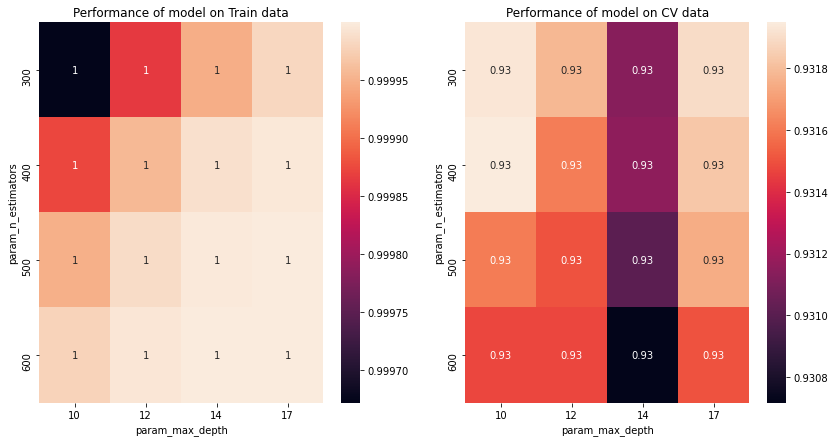

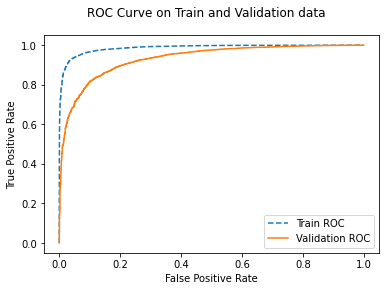

In [62]:
optimum_params_tfidf_xgb=XGBGridsearchcv(tfidf_train, Y_train, tfidf_test, Y_test)

Best AUC score on optimum parameters is: 0.93561


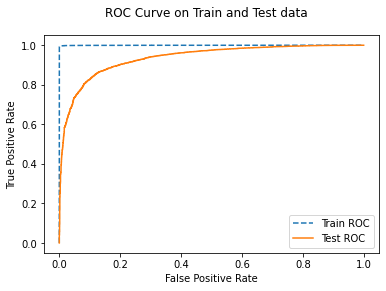

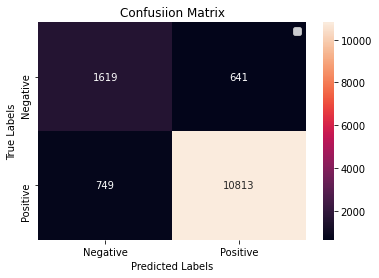

In [63]:
xgbClassifireModel(tfidf_train, Y_train,  tfidf_test, Y_test, optimum_params_tfidf_xgb)

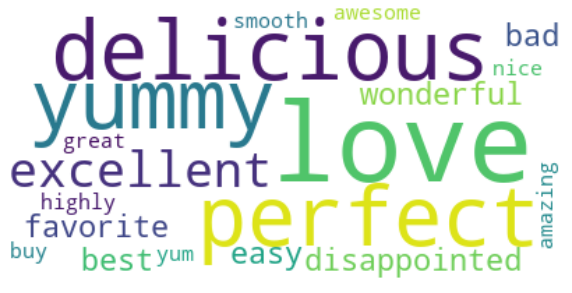

,Features,Gini Importance
1,perfect,0.018960
2,delicious,0.018389
3,yummy,0.016835
4,excellent,0.013616
5,disappointed,0.011967
6,best,0.011890
7,loves,0.011021
8,bad,0.010266
9,favorite,0.010205
10,easy,0.010192


In [64]:
imp_features_df=getImportantFeatures(xgb_clf, tfidfVector)
displayWordCould(imp_features_df['Features'])
imp_features_df

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
avgw2v_train, avgw2v_test, tfidf_w2v_train, tfidf_w2v_test=map(np.array, [avgw2v_train, avgw2v_test, tfidf_w2v_train, tfidf_w2v_test])

[09:18:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 47.4min finished


Best parameters are: {'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 10, 'n_estimators': 600, 'predictor': 'auto', 'scale_pos_weight': 0.2, 'tree_method': 'hist'}


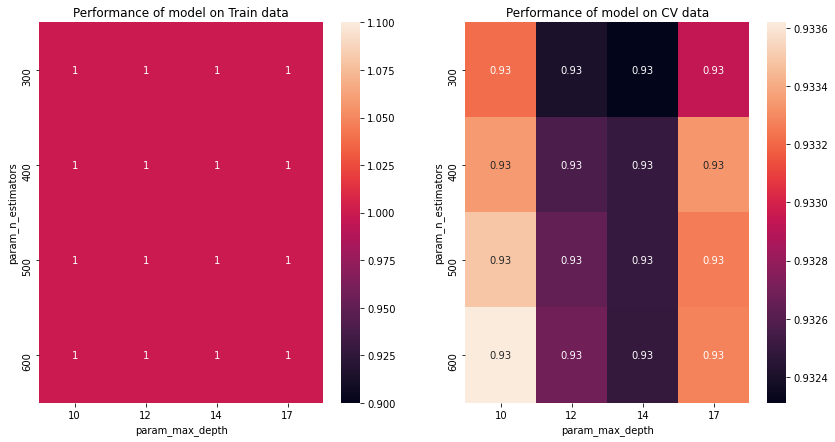

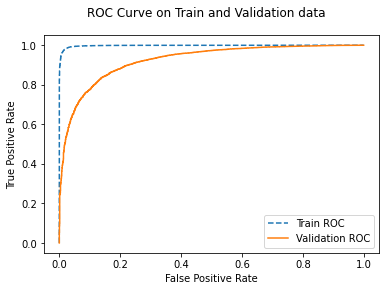

In [ ]:
optimum_params_avgw2v_xgb=XGBGridsearchcv(avgw2v_train, Y_train, avgw2v_test, Y_test)

Best AUC score on optimum parameters is: 0.92951


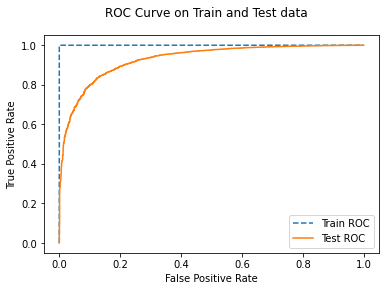

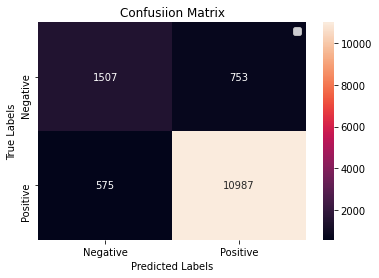

In [ ]:
xgbClassifireModel(avgw2v_train, Y_train, avgw2v_test, Y_test, optimum_params_avgw2v_xgb)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

[08:24:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 52.8min finished


Best parameters are: {'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 10, 'n_estimators': 600, 'predictor': 'auto', 'scale_pos_weight': 0.2, 'tree_method': 'hist'}


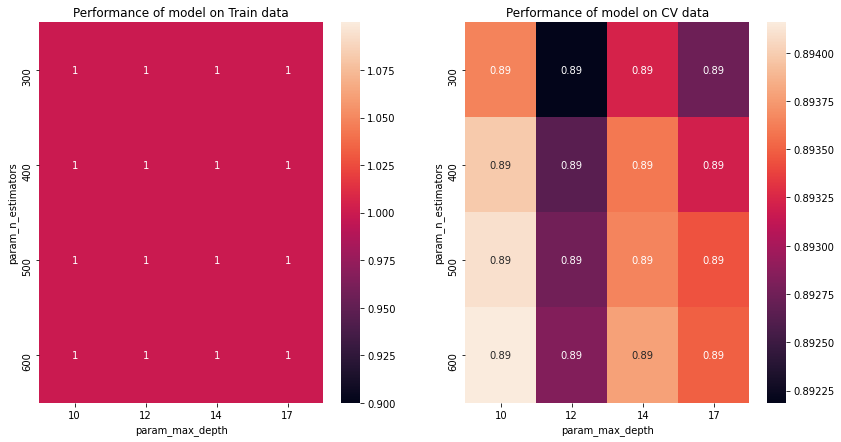

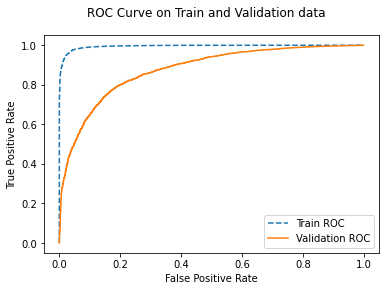

In [ ]:
optimum_params_tfidf_avgw2v_xgb=XGBGridsearchcv(tfidf_w2v_train, Y_train, tfidf_w2v_test, Y_test)

Best AUC score on optimum parameters is: 0.88398


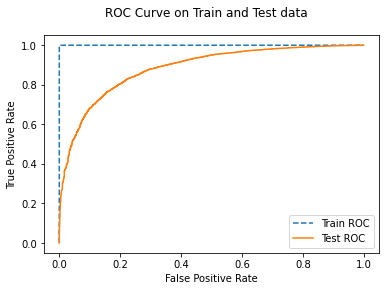

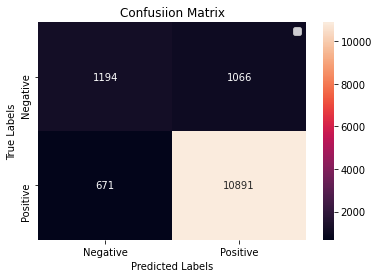

In [ ]:
xgbClassifireModel(tfidf_w2v_train, Y_train, tfidf_w2v_test, Y_test, optimum_params_tfidf_avgw2v_xgb)

In [65]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names=['Model', 'Vectorizer', 'Max Depth', 'Number of Base learners', 'Test AUC score']

x.add_row(['XGBoost', 'bow', '10', '500', '0.96761'])
x.add_row(['XGBoost','tfidf', '10' ,'400' ,'0.93561'])
x.add_row(['XGBoost','avg_w2v', '10' ,'600' ,'0.92951'])
x.add_row(['XGBoost','tfidf_avgw2v', '10' ,'600' ,'0.88398'])

print(x)

+---------+--------------+-----------+-------------------------+----------------+
|  Model  |  Vectorizer  | Max Depth | Number of Base learners | Test AUC score |
+---------+--------------+-----------+-------------------------+----------------+
| XGBoost |     bow      |     10    |           500           |    0.96761     |
| XGBoost |    tfidf     |     10    |           400           |    0.93561     |
| XGBoost |   avg_w2v    |     10    |           600           |    0.92951     |
| XGBoost | tfidf_avgw2v |     10    |           600           |    0.88398     |
+---------+--------------+-----------+-------------------------+----------------+


# [6] Conclusions

- BagOfWords represntation of vectors yielded maximum AUC score of 0.96761
- Top features on BoW and tfidf are almost same
- XGBoost can be implemented using GPU but we used CPU to bulid this model